In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [4]:
import json
from tqdm.auto import tqdm
from itertools import islice
from collections import Counter
import textwrap

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

from morphen.delta_classifier import (
    get_delta_vec,
    feature_extraction)


In [5]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv",          
         "../data/10.02-word-split.json",
         "../data/delta_tenc_d200_biwords.bin"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin a00518


## Load resources

In [27]:
from opencc import OpenCC
t2s = OpenCC('t2s').convert

In [6]:
mr_data = pd.read_csv("../data/verb_morpho.csv", index_col=0)
kv = KeyedVectors.load_word2vec_format("../data/delta_tenc_d200_biwords.bin", binary=True)
with open("../data/10.02-word-split.json", "r", encoding="UTF-8") as fin:
    word_split = json.load(fin)

In [7]:
mr_data_train = mr_data.loc[mr_data.token.isin(word_split["train"]),:]
mr_data_test = mr_data.loc[mr_data.token.isin(word_split["test"]),:]

## Morphology EDA

In [21]:
Counter(x[0] for x in kv.key_to_index
        if len(x) == 2 and "*" not in x).most_common()[10:15]

[('高', 364), ('多', 361), ('王', 350), ('张', 350), ('新', 341)]

In [20]:
Counter(x[1] for x in kv.key_to_index
        if len(x) == 2 and "*" not in x).most_common()[10:15]

[('水', 372), ('家', 351), ('过', 349), ('头', 347), ('道', 333)]

In [22]:
import re
delta_pat = re.compile(r"d.\([头道]\|")
candids = []
for tok in kv.key_to_index:
    if delta_pat.match(tok):
        candids.append(tok)
len(candids)

889

In [49]:
vecs = [kv.get_vector(x) for x in candids]

In [137]:
tgt = "味*"
neighs = kv.most_similar(t2s(tgt), topn=30)
neighs = [x for x, _ in neighs if "*" not in x and not x.startswith("d")]
neighs.append(tgt)
vecs = np.vstack([kv.get_vector(x) for x in neighs])

In [138]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE

In [139]:
import networkx as nx
import plotly.graph_objects as go
from sklearn.neighbors import kneighbors_graph

In [158]:
nn_a = kneighbors_graph(vecs, 3)
Ga = nx.from_scipy_sparse_matrix(nn_a)
nx.graph_clique_number(Ga)

4

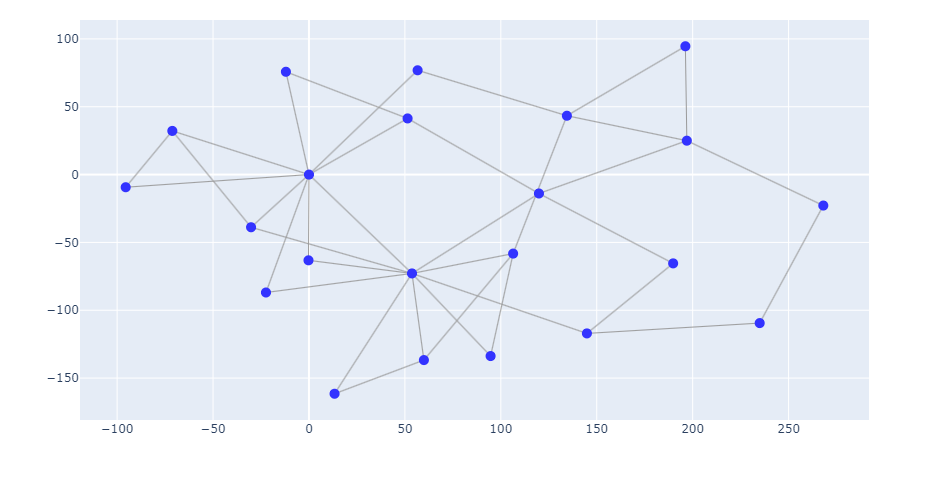

In [140]:
## https://plotly.com/python/network-graphs/
nn = kneighbors_graph(vecs, 2)
G = nx.from_scipy_sparse_matrix(nn)
edge_x = []; edge_y = []
node_pos = nx.nx_pydot.pydot_layout(G)
refx, refy = node_pos[len(node_pos)-1]
node_pos = {k: [v[0]-refx, v[1]-refy] for k, v in node_pos.items()}
node_x = [x[0] for x in node_pos.values()]
node_y = [x[1] for x in node_pos.values()]

for edge in G.edges():
    src, tgt = edge
    x0, y0 = node_pos[src]    
    x1, y1 = node_pos[tgt]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color="#999"),
    hoverinfo='none',
    mode='lines',
    showlegend=False)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers",
    hoverinfo='text',
    marker=dict(size=10, color="#33F"),
    showlegend=False)
node_trace.text = neighs
fig = go.Figure(data=[edge_trace, node_trace], 
                layout=go.Layout(
                    width=800, height=500, margin={"t": 20}))
fig.show()

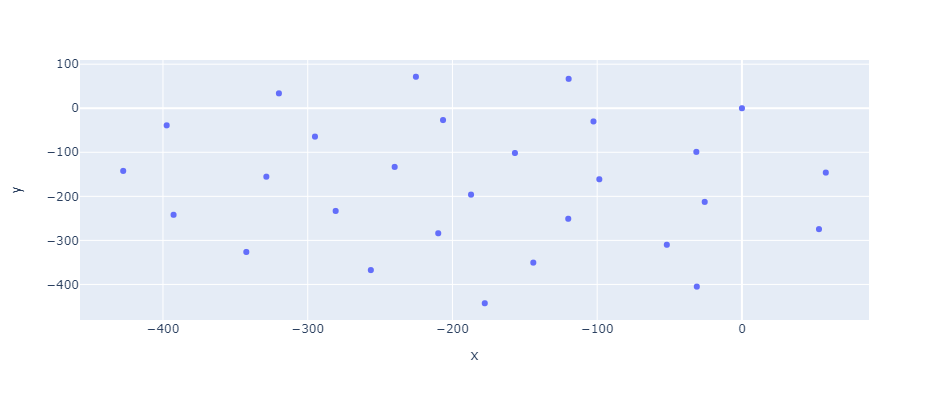

In [58]:
import plotly.express as px

tsne = TSNE()
proj = tsne.fit_transform(vecs)
proj = proj - proj[-1, :]
fig = px.scatter(x=proj[:,0], y=proj[:,1], hover_data=[neighs])
fig.update_layout(width=600, height=400)

In [ ]:
Xvecs, ylabels = feature_extraction("c1+c2", train_entries, kv)
Xtest, ytest = feature_extraction("c1+c2", inkv_test_entries, kv)
lda = LinearDiscriminantAnalysis()
lda.fit(Xvecs, ylabels)
ypred = lda.predict(Xtest)
print("Acc of LDA (c1+c2) trained on full data, but test on words in KV only: {:.2f}".format(
        accuracy_score(ytest, ypred)))
print("Compared with LDA (c1+c2) with trained on words in KV only: .56 ± .02")